##**Libraries**##

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

##**Loading dataset and show some example**##

In [101]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [ ]:
import keras
from keras.datasets import mnist
from keras.utils import to_categorical, np_utils
from keras.datasets import mnist
import tensorflow as tf
def load_data(keras_datasets, first_layer="dense", channels=1, plot_images=False, class_names=[]):
    (x_train, y_train), (x_test, y_test) = keras_datasets.load_data()
    print('Before reshape - X_train.shape:', x_train.shape)
    print('Before reshape - X_test.shape:', x_test.shape)
    height=x_train.shape[1]
    width=x_train.shape[2]        
    # flatten 28*28 images to a 784 vector for each image
    num_pixels = height * width

    # convert shape of x_train from (60000, 28, 28) to (60000, 784) - 784 columns per row        
    X_train = x_train.reshape((x_train.shape[0], num_pixels)).astype('float32')
    X_test = x_test.reshape((x_test.shape[0], num_pixels)).astype('float32')        

        
    print('After reshape - X_train.shape:', X_train.shape)
    print('After reshape - X_test.shape:', X_test.shape)
    #print('Before rescaling:', X_train[0])
    #normalize the values between 0 and 1
    X_train = (X_train.astype(np.float32))/255
    X_test = (X_test.astype(np.float32))/255
    #print('After rescaling:', X_train[0])
              
    #convert labels to categorical/dummy encoding so that we can use simple "categorical_crossentropy" as loss.
    #print('Class label of first image before converting to categorical:', y_train[0])
    # one hot encode outputs
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    num_classes = y_test.shape[1]
    print('Total number of classes:', num_classes)
    #print('Class label of first image after converting to categorical:', y_train[0])
              
    return (X_train, y_train, X_test, y_test)
NUM_CLASSES=10
CLASS_NAMES = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
X_train, y_train, X_test, y_test= load_data(tf.keras.datasets.fashion_mnist, first_layer="dense", channels=1, plot_images=True, class_names=CLASS_NAMES)

Before reshape - X_train.shape: (60000, 28, 28)
Before reshape - X_test.shape: (10000, 28, 28)
After reshape - X_train.shape: (60000, 784)
After reshape - X_test.shape: (10000, 784)
Total number of classes: 10


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(60000, 10)


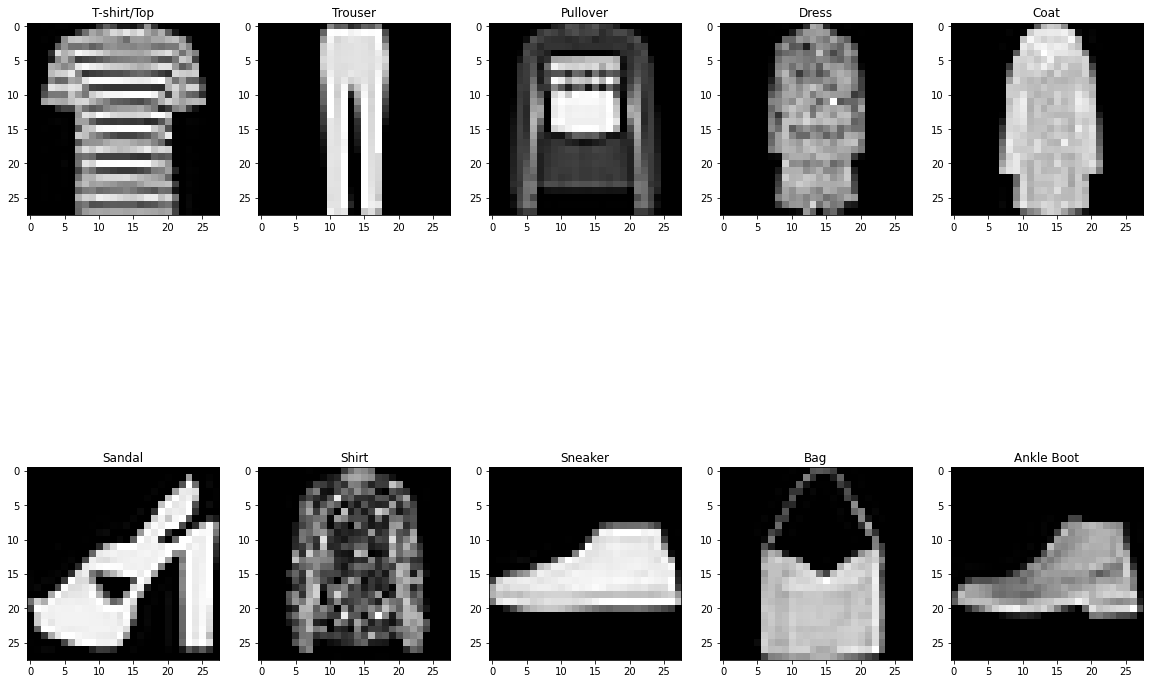

In [100]:
T_shirt_Top=[]
Trouser=[]
Pullover=[]
Dress=[]
Coat=[]
Sandal=[]
Shirt=[]
Sneaker=[]
Bag=[]
Ankle_Boot=[]
output_mapping = {
                 0: T_shirt_Top,
                 1: Trouser,
                 2: Pullover,
                 3: Dress,
                 4: Coat, 
                 5: Sandal, 
                 6: Shirt,
                 7: Sneaker,
                 8: Bag,
                 9: Ankle_Boot
    }
yy=np.argmax(y_train, axis=1)
for i in range(len(X_train)):
  image=X_train[i]
  label=yy[i]
  input = (label.item() if type(label) == torch.Tensor else label)
  output_mapping[input].append(i)
def name_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
fig = plt.figure(figsize=(20, 15))
for i in range(len(output_mapping)):
  fig.add_subplot(2,5, i+1)
  num= np.random.choice(output_mapping[i], size=1)
  image = X_train[num[0]].reshape(28,28)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(name_label(i))

##**Multilayer perceptron network**##

In [ ]:
class MLP:
    def __init__(self, n_i, n_h, n_o, activation='sigmoid', max_epochs=5000,
                 learning_rate=0.1, verbose=2):
        """ Initialize the whole network
        :param n_i: The number of units in the input layer
        :param n_h: The number of units in the hidden layer
        :param n_o: The number of units in the output layer
        :param activation: The activation function for activating the weights and inputs
        :param max_epochs: The maximum iterations to training the MLP, to adjust weights
        :param learning_rate: Indicating how much the delta on weights would be accepted
        :param verbose: How much details should be printed during the training
        """

        self.n_i = n_i
        self.n_h = n_h
        self.n_o = n_o
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.verbose = np.power(10, verbose-1)
        # Initialize the activation function and its derivative functions
        self.activation, self.d_activation = \
            self.__initialize_activation_func(activation)

        # Initialize the loss function
        self.__initialize_loss_func()

        # Initialize the units to hold activation results
        self.input = np.ones(self.n_i + 1)  # 1 for bias
        self.h = np.ones(self.n_h)
        self.o = np.ones(self.n_o)

        # Initialize the weights of the lower layer and the upper layer
        self.W1, self.W2 = self.__initialize_weights()

    def __initialize_activation_func(self, activation):
        """ Initialize the activation function and its derivative function
        :param activation: The symbol of activation, taking a string
        :return: The assigned activation function and its derivative
        """
        # Temporarily using tanh - a rescaled logistic sigmoid function
        return tanh, d_tanh

    def __initialize_loss_func(self):
        """ Initialize the loss function
        - when n_o > 1, classification should apply cross entropy
        - when n_o = 1, like a regression problem, should use squared error
        :return: None
        """
        self.loss_func = cross_entropy

    def __initialize_weights(self):
        """ Randomly initialize weights between -1 and 1
                for the lower layer and the upper layer
        :return: The initialized weights
        """
        w1 = np.random.uniform(-0.2, 0.2, (self.input.size, self.h.size))
        w2 = np.random.uniform(-0.2, 0.2, (self.h.size, self.o.size))
        return w1, w2

    def __forwards(self, inputs):
        """ Propagate the inputs forward from the input layer
                to the output layer
        :param inputs: The training example
        :return: The output on output units
        """

        # In the input layer, the last one is 1 for bias
        self.input[:-1] = inputs
        # Activate the hidden layer
        self.h = self.activation(np.dot(self.input, self.W1))
        self.o = softmax(np.dot(self.h, self.W2))

        return self.o

    def __backwards(self, expected):
        """ The core training technique.
                Propagate the error signal back to each layer,
                and adjust the weights
        :param expected: The expected outputs for calculating the error
        :return: None
        """

        # The error on the output layer
        error = expected - self.o
        # Computing the delta activation of the output layer
        dz2 = error * d_softmax(self.o, softmax)
        # Computing the delta activation of the hidden layer
        dz1 = np.dot(dz2, self.W2.T) * self.d_activation(self.h)

        # Update the weights
        self.__update_weights(dz1, dz2)

    def __update_weights(self, dz1, dz2):
        """ Update weights on the lower layer and the upper layer
        :param dz1: The delta on the hidden layer
        :param dz2: The delta on the output layer
        :return: None
        """
        dw1 = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(dz1))
        self.W1 += self.learning_rate * dw1
        dw2 = np.dot(np.atleast_2d(self.h).T, np.atleast_2d(dz2))
        self.W2 += self.learning_rate * dw2

    def fit(self, X, y,X_test,y_test):
        """ Training the MLP network by the training set
        Adjust the weights by iterate the training set max-epoch times
        :param X: The features of the training set
        :param y: The labels/Outputs of the training set
        :return: self
        """
        for e in range(1, self.max_epochs):
            loss = 0.
            for j, row in enumerate(X):
                # feed-forward the inputs to the output layer
                o = self.__forwards(row)
                # Accumulate the error of each example computed
                #   by the loss function to get the total loss
                loss += self.loss_func(o, y[j])
                # Back-propagate the error signal computed
                #   according to the given expected output
                self.__backwards(y[j])

            # Print details during training
            if self.n_o > 1:
                # Classification
                # Predict the training set and print the current accuracy
                pre = self.predict(X)
                acc = 0.
                for k, _ in enumerate(y):
                    if pre[k] == np.argmax(y[k]):
                        acc += 1
                prediction_test = self.predict(X_test)
                acc_test=0
                for k, _ in enumerate(y_test):
                    if prediction_test[k] == np.argmax(y_test, axis=1)[k]:
                        acc_test += 1
                
                if e % self.verbose == 0:
                    print('epoch %d | cost : %.3f | accuracy of traning : %.3f | accuracy for testing: %.3f' %
                          (e, loss/len(X), acc/len(X),acc_test/len(prediction_test))) 
                    
            else:
                if e % self.verbose == 0:
                    # Regression - print the cost (average loss on training dataset)
                    print('epoch %d | cost : %.3f' % (e, loss/(len(X))))

        return self

    def predict(self, X):
        """ Predict on the test set
        :param X: The unseen features of the test set
        :return: The predicted output for each example in the test set
        """
        y = list()
        for j, row in enumerate(X):
                # Classification - using one hot encoding,
                #   so find the index of output units with the max output
                y.append(np.argmax(self.__forwards(row)))
        return np.array(y)


# Definitions of sigmoid, derivatives, SoftMax, and loss functions
def tanh(x):
    """ The rescaled logistic sigmoid function
    :param x: The input needs to be activated
    :return: corresponding tanh value with the input x
    """
    return np.tanh(x)


def d_tanh(x):
    """ The derivative of the tanh activation function
    :param x: The input value
    :return: The derivative
    """
    return 1.0 - x**2


def softmax(x):
    """ Compute the SoftMax of vector x in a numerically stable way,
            since numpy's exp would lead to infinite (nan)
    :param x: In Classification, the inputs on the output units need to be activated
    :return: The probabilities on each output unit. The sum should be 1.
    """
    shiftx = x - np.max(x)
    exps = np.exp(shiftx)
    return exps / np.sum(exps)


def d_softmax(o, f):
    """ The derivative of SoftMax with respect to the output
    :param o: The output
    :param f: The activation function of the output layer - SoftMax in classification
    :return: The derivative
    """
    return f(o) * (1 - f(o))


def cross_entropy(o, y):
    """ Cross entropy loss function
    :param o: The output
    :param y: The expected output
    :return: The cross entropy - the loss
    """
    return np.sum(np.nan_to_num(-y * np.log(o) - (1-y) * np.log(1-o)))


def squared_error(o, y):
    """ Squared error loss function
    :param o: The output
    :param y: The expected output
    :return: The square error - the loss
    """
    return 0.5 * ((y-o) ** 2).sum()


##**Define model**##

In [ ]:

mlp = MLP(X_train.shape[1], 30, y_train.shape[1], learning_rate=0.1, max_epochs=10, verbose=1)

##**Train model**##

In [ ]:
mlp.fit(X_train, y_train,X_test,y_test)

epoch 1 | cost : 0.920 | accuracy of traning : 0.845 | accuracy for testing: 0.830
epoch 2 | cost : 0.753 | accuracy of traning : 0.853 | accuracy for testing: 0.838
epoch 3 | cost : 0.714 | accuracy of traning : 0.855 | accuracy for testing: 0.837
epoch 4 | cost : 0.697 | accuracy of traning : 0.864 | accuracy for testing: 0.849
epoch 5 | cost : 0.683 | accuracy of traning : 0.862 | accuracy for testing: 0.842
epoch 6 | cost : 0.681 | accuracy of traning : 0.863 | accuracy for testing: 0.840
epoch 7 | cost : 0.693 | accuracy of traning : 0.863 | accuracy for testing: 0.846
epoch 8 | cost : 0.702 | accuracy of traning : 0.859 | accuracy for testing: 0.840
epoch 9 | cost : 0.696 | accuracy of traning : 0.864 | accuracy for testing: 0.846


##**Test model**##

In [ ]:
prediction = mlp.predict(X_test)
acc=0
for k, _ in enumerate(y_test):
  if prediction[k] == np.argmax(y_test, axis=1)[k]:
    acc += 1
print(acc/len(prediction))

0.8455


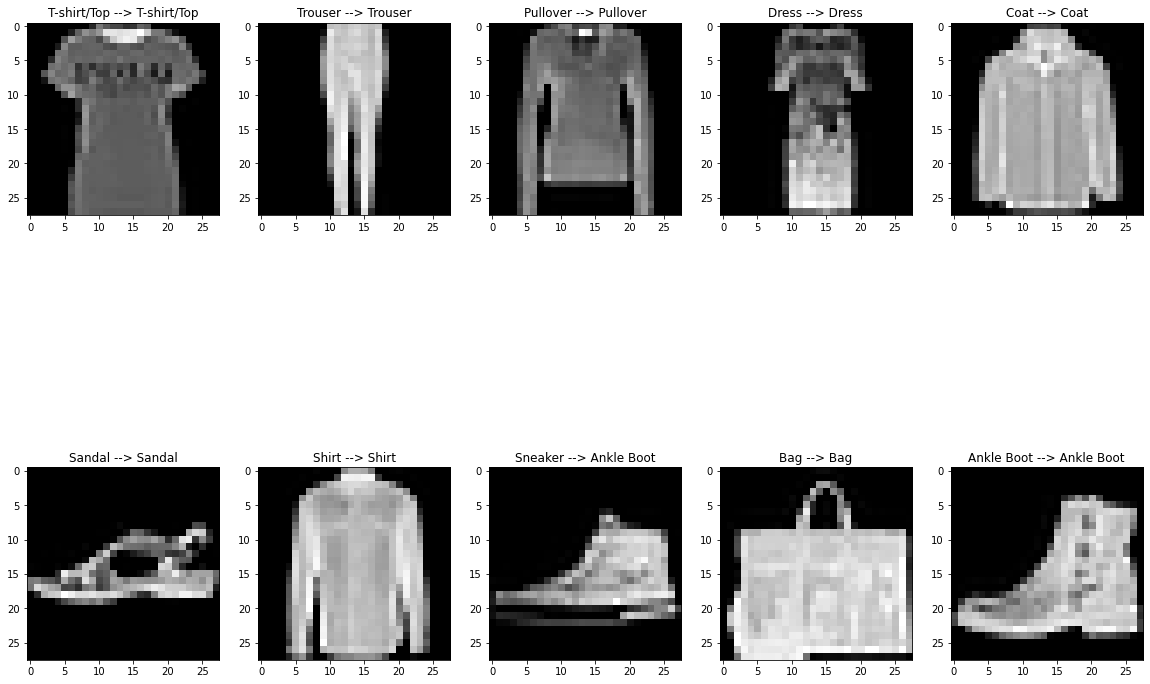

In [ ]:
T_shirt_Top=[]
Trouser=[]
Pullover=[]
Dress=[]
Coat=[]
Sandal=[]
Shirt=[]
Sneaker=[]
Bag=[]
Ankle_Boot=[]
output_mapping = {
                 0: T_shirt_Top,
                 1: Trouser,
                 2: Pullover,
                 3: Dress,
                 4: Coat, 
                 5: Sandal, 
                 6: Shirt,
                 7: Sneaker,
                 8: Bag,
                 9: Ankle_Boot
    }

for i in range(len(X_test)):
  image=X_test[i]
  label=np.argmax(y_test, axis=1)[i]
  input = (label.item() if type(label) == torch.Tensor else label)
  output_mapping[input].append(i)
def name_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]
fig = plt.figure(figsize=(20, 15))
for i in range(len(output_mapping)):
  fig.add_subplot(2,5, i+1)
  num= np.random.choice(output_mapping[i], size=1)
  image = X_test[num[0]].reshape(28,28)
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(name_label(i)+" --> "+name_label(prediction[num[0]]))